План действий
1) Проверить по датам - как там с целостностью и когда она упала
2) Проверить по причинам, какая причина отмен самая популярная и была ли она популярной раньше
3) Может проблема в конкретном сторе ? сколько каждый стор внес в провент оз 
4) Посмотреть на время сборки - может очень много заказов и мало сборщиков и им просто в падлу было искать товары

## Даты теста отключения OOS: 20.06 - 29.06

In [1]:
test_start = '2023-06-20'
test_end = '2023-06-29'
# Перезапустить на с 1 мая
start_date = '2023-06-01'
end_date = '2023-07-27'

In [2]:
import sys
sys.path.append('/home/jovyan/modules')
from pre import *
from connectors import *
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)

# Выгрузка данных

In [3]:
# %%time
# df_list=[]

# for date in tqdm(pd.date_range(start='2023-07-20', end='2023-07-27')):
#     print(date.strftime("%Y-%m-%d"))
#     df_list.append(read_sql_query(f'''
#     SELECT
#         toDate(shipment_shipped_at) AS date,
#         master_category,
#         city,
#         express_delivery,
#         retailer_name,
#         tenant_id,
#         sumIf(1, rc_status != 'ok') AS rc_count,
#         sumIf(1, rc_status = 'replaced') AS repl_count,
#         sumIf(1, rc_status = 'cancelled') AS canc_count,
#         sum(multiIf((rc_status = 'cancelled') OR (is_deleted = 0), 1, 0)) AS total_cnt
#     FROM
#     (
#         SELECT
#             product_name,
#             brand_name,
#             toDate(shipment_shipped_at, 'Europe/Moscow') AS shipment_shipped_at,
#             master_category,
#             dictGet('analytics.master_categories_dict', 'parent_id', toUInt64(parent_category_id)) AS master_category_3_id,
#             dictGet('analytics.master_categories_dict', 'name', toUInt64(parent_category_id)) AS master_category_2,
#             dictGet('analytics.master_categories_dict', 'name', toUInt64(master_category_3_id)) AS master_category_3,
#             city AS city,
#             dictGet('analytics.store_details_dict', 'veeroute_identifier', toUInt64(store_id)) AS store_name,
#             dictGet('analytics.stores_dict', 'express_delivery', toUInt64(store_id)) AS express_delivery,
#             retailer_name AS retailer_name,
#             tenant_id AS tenant_id,
#             if((lv.line_item_id IS NOT NULL) AND (lv.line_item_id != 0), lv.to_item_id, 1) AS replaced_to,
#             multiIf(replaced_to = 1, 'ok', replaced_to IS NULL, 'cancelled', 'replaced') AS rc_status,
#             multiIf(dictGet('analytics.device_attributions_dict', 'client_identifier', toUInt64(order_id)) != '', dictGet('analytics.device_attributions_dict', 'client_identifier', toUInt64(order_id)), tenant_id = 'metro', 'WL Metro', 'SbermarketWeb') AS client_identifier,
#             multiIf(li_deleted_at IS NOT NULL, 1, 0) AS is_deleted
#         FROM analytics.line_items AS li
#         LEFT JOIN
#         (
#             SELECT
#                 line_item_id,
#                 max(to_item_id) AS to_item_id
#             FROM analytics.lirc_view
#             GROUP BY line_item_id
#         ) AS lv ON lv.line_item_id = toUInt64(li.line_item_id)
#         WHERE (toDate(shipment_shipped_at, 'Europe/Moscow') = toDate('{date}', 'Europe/Moscow')) AND (shipment_state = 'shipped')
#     ) AS li_rc
#     GROUP BY
#         date,
#         master_category,
#         city,
#         express_delivery,
#         retailer_name,
#         tenant_id

    
#     '''))
    

In [4]:
# final_df = pd.concat(df_list)
# final_df.reset_index(inplace=True)
# final_df.to_feather('rc_final_df.feather')

In [217]:
final_df = pd.read_feather('rc_final_df.feather')

In [225]:
final_df = final_df[final_df['date']!=pd.to_datetime(end_date)]

In [226]:
final_df_group = \
final_df.groupby('date')[['rc_count','repl_count','canc_count','total_cnt']].sum()\
.reset_index()

In [227]:
final_df_group['rc_prc']=final_df_group['rc_count']/final_df_group['total_cnt']
final_df_group['rep_prc']=final_df_group['repl_count']/final_df_group['total_cnt']
final_df_group['canc_prc']=final_df_group['canc_count']/final_df_group['total_cnt']

In [228]:
#final_df_group = final_df_group[5:-2]

# Декомпозиция ОЗ

Text(0.5, 1.0, 'Процент отмен, замен и их сумма')

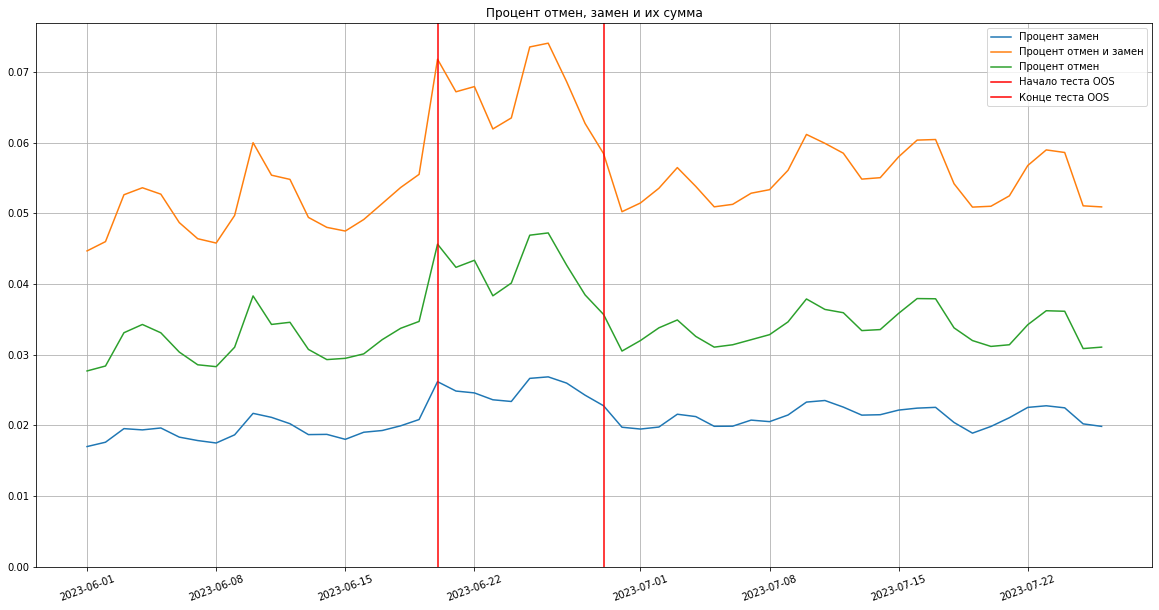

In [229]:
#plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.plot(final_df_group.date, final_df_group.rep_prc, label ='Процент замен')
plt.plot(final_df_group.date, final_df_group.rc_prc, label ='Процент отмен и замен')
plt.plot(final_df_group.date, final_df_group.canc_prc, label ='Процент отмен')

plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'Начало теста OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r', label = 'Конце теста OOS')
plt.xticks(rotation=20)
plt.grid()
plt.legend()
plt.ylim(0,)
plt.title("Процент отмен, замен и их сумма")

# Сравниваем с количеством заказов

Text(0.5, 1.0, 'Количество заказанных позиций')

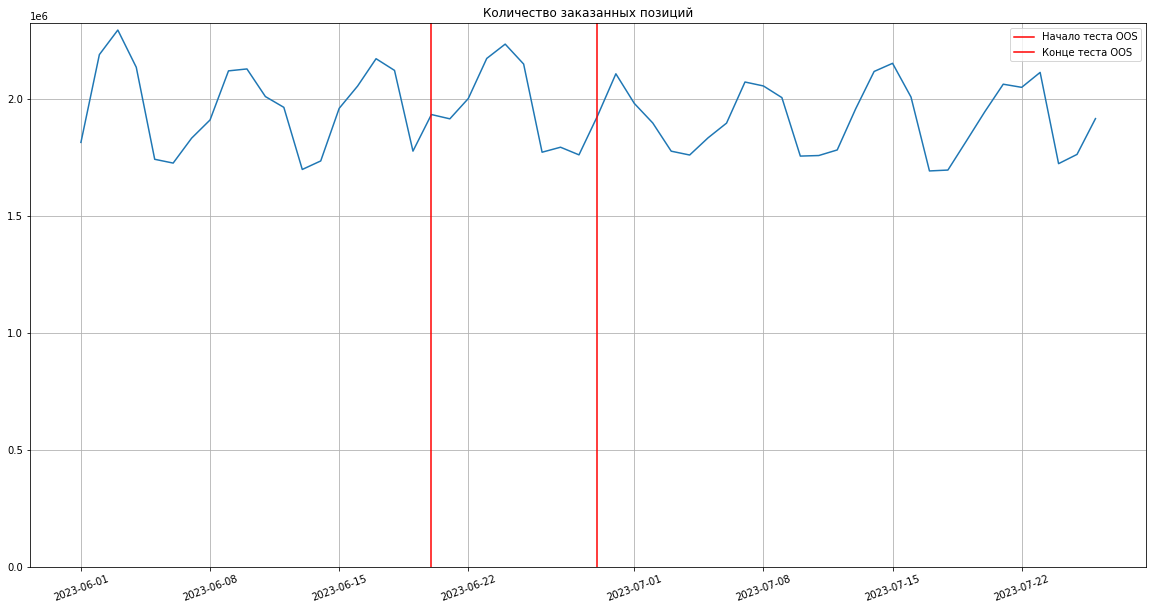

In [230]:
plt.figure(figsize=(20,10))
plt.plot(final_df_group.date, final_df_group.total_cnt.astype(int))
plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'Начало теста OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r', label = 'Конце теста OOS')
plt.xticks(rotation=20)
plt.grid()
plt.legend()
plt.ylim(0,)

plt.title("Количество заказанных позиций")

Заказы как обычно

Text(0.5, 1.0, 'ОЗ и заказанные позиции')

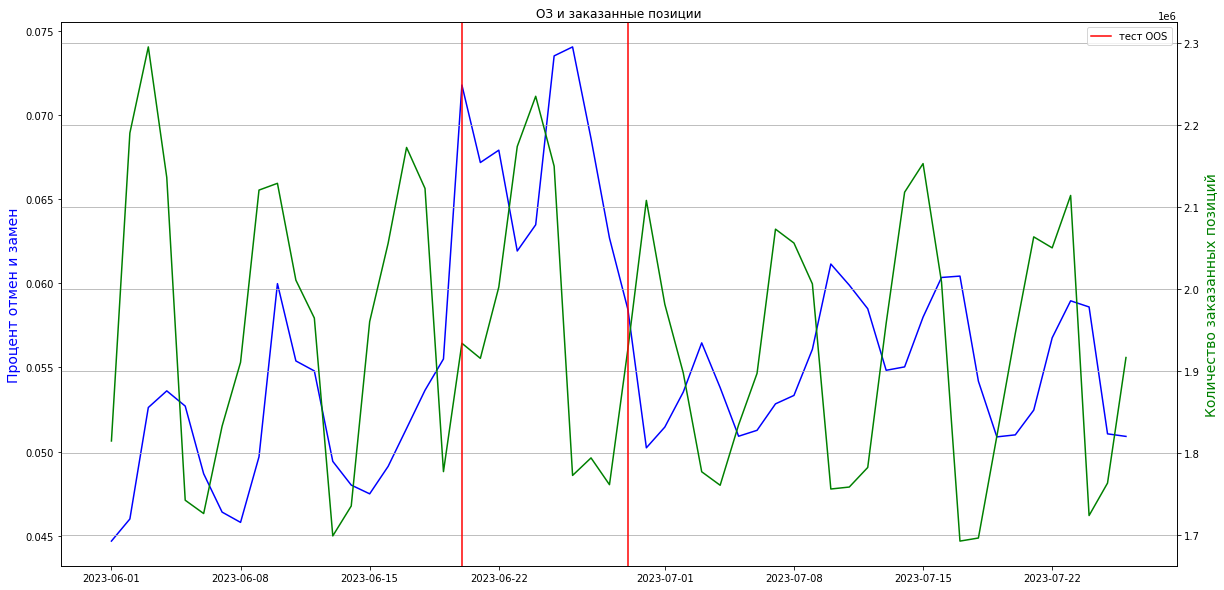

In [303]:
#define colors to use
col1 = 'b'
col2 = 'g'

#define subplots
fig,ax = plt.subplots(figsize=(20,10))
#plt.figure(figsize=(20,10))

#add first line to plot
ax.plot(final_df_group.date, final_df_group.rc_prc, color=col1)

#add x-axis label
ax.set_ylabel('Процент отмен и замен', fontsize= 14 ,color=col1)


#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx ()

#add second line to plot
ax2.plot(final_df_group.date, final_df_group.total_cnt , color=col2)

#add second y-axis label
ax2.set_ylabel('Количество заказанных позиций', color=col2, fontsize= 14 )


plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'тест OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r')

plt.xticks(rotation=20)

plt.grid(axis='both')

plt.legend()
plt.title("ОЗ и заказанные позиции")

Видим, что ОЗ и коллиечство заказанных позиций разнонаправлены - максимумы ОЗ наблюдатся в минимумы заказов (в правой части)

# Проверим количество заказовов на одного сборщика - возможно, дело в их нехватке?

In [232]:
start_date = final_df_group.date.min().strftime('%Y-%m-%d')
end_date = final_df_group.date.max().strftime('%Y-%m-%d')

In [233]:
num_of_shoppers = read_sql_query(f'''select 
toDate(shipped_at) as date,
uniq(shopper_login) as uniq_shoppers
from shipments
where shipped_at between toDate('{start_date}') and toDate('{end_date}') 
and completed_at between toDate('{start_date}') and toDate('{end_date}') 
group by date
order by date''')

In [234]:
num_of_shoppers = num_of_shoppers.merge(final_df_group[['total_cnt','date','rc_prc']])

In [235]:
num_of_shoppers.columns=['date','uniq_shoppers','num_orders','rc_prc']
num_of_shoppers['order_per_shopper'] = \
num_of_shoppers['num_orders']/num_of_shoppers['uniq_shoppers']
num_of_shoppers['order_per_shopper'] = num_of_shoppers['order_per_shopper'].astype(int)
# num_of_shoppers['rc_prc'] = \
# num_of_shoppers['rc_prc'].apply(lambda x: np.round(x*100,1))

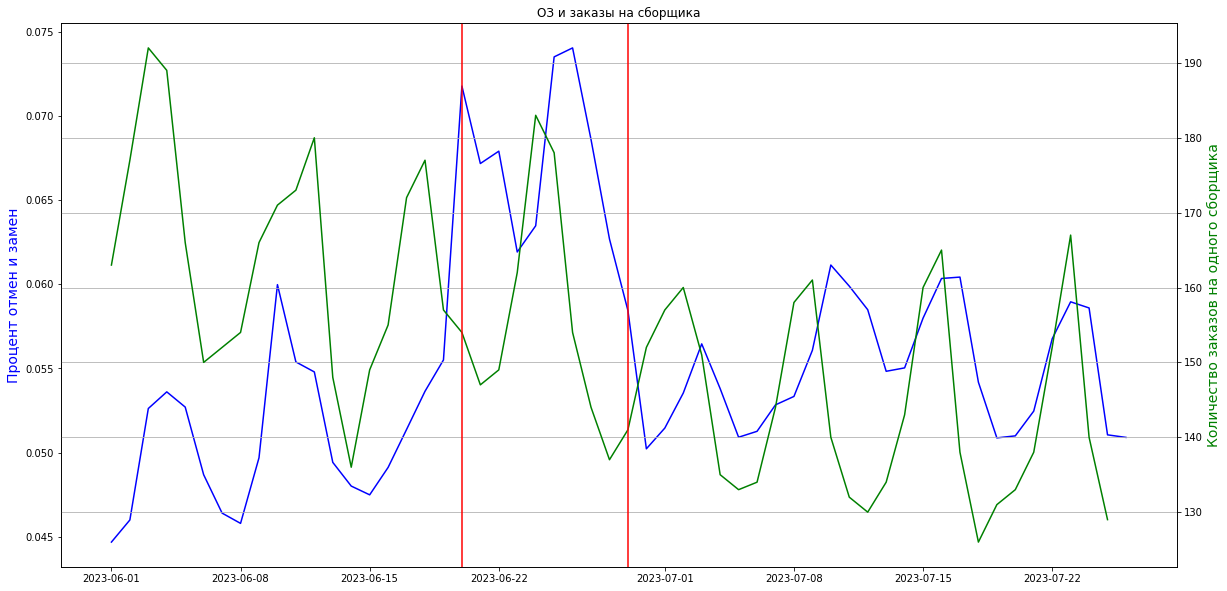

In [236]:
#define colors to use
col1 = 'b'
col2 = 'g'

#define subplots
fig,ax = plt.subplots(figsize=(20,10))
#plt.figure(figsize=(20,10))

#add first line to plot
ax.plot(final_df_group.date, final_df_group.rc_prc, color=col1)

#add x-axis label
ax.set_ylabel('Процент отмен и замен', fontsize= 14 ,color=col1)

#add y-axis label


#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx ()

#add second line to plot
ax2.plot(num_of_shoppers.date, num_of_shoppers.order_per_shopper , color=col2)

plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'Начало теста OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r', label = 'Конце теста OOS')


#add second y-axis label
ax2.set_ylabel('Количество заказов на одного сборщика', color=col2, fontsize= 14 )
plt.title("ОЗ и заказы на сборщика")
plt.grid(axis='both')

Видим, что ОЗ прям коррелируют с заказами на сборщиков: чем больше заказов на сборщика - тем выше ОЗ, но заказов было много и в начале июня, когда ОЗ были низкими

# По причинам, какая причина отмен самая популярная и была ли она популярной раньше

In [237]:
%%time
assembly_issue_df = \
read_sql_query(f'''
select 
toDate(shipment_shipped_at, 'Europe/Moscow') as date,
                assembly_issue,
                count(*) as items_cnt
            FROM (
             SELECT
                 line_item_id,
                 max(to_item_id) AS to_item_id
             FROM analytics.lirc_view
             GROUP BY line_item_id
         ) AS lv 
         INNER JOIN ( 
         select * from analytics.line_items 
         where toDate(shipment_shipped_at) 
            between toDate('{start_date}') and toDate('{end_date}')
         and assembly_issue is not null)
         li ON lv.line_item_id = toUInt64(li.line_item_id)
            
            group by date, assembly_issue
''')

CPU times: user 315 ms, sys: 97.3 ms, total: 413 ms
Wall time: 2min 36s


In [238]:
assembly_issue_df_agg = \
pd.pivot_table(assembly_issue_df, values='items_cnt', index=['date'],
                    columns=['assembly_issue'], aggfunc=np.sum).fillna(0)\
.reset_index().merge(assembly_issue_df.groupby('date')['items_cnt']\
                     .sum().reset_index())

In [239]:
dict_cate = {}
for el in assembly_issue_df_agg.columns[1:-1]:
    dict_cate[el] = assembly_issue_df_agg[el].sum()

In [240]:
res_columns = []
for el in sorted(set(list(dict_cate.values()))):
    for k in dict_cate:
        if dict_cate[k]==el:
            res_columns.append(k)


In [241]:
res_columns = res_columns[-1:1:-1]

In [242]:
assembly_issue_df_agg = assembly_issue_df_agg[['date']+res_columns+['items_cnt']]

In [243]:
for el in assembly_issue_df_agg.columns[1:-1]:
    assembly_issue_df_agg[el] = \
    assembly_issue_df_agg[el]*100/assembly_issue_df_agg.items_cnt

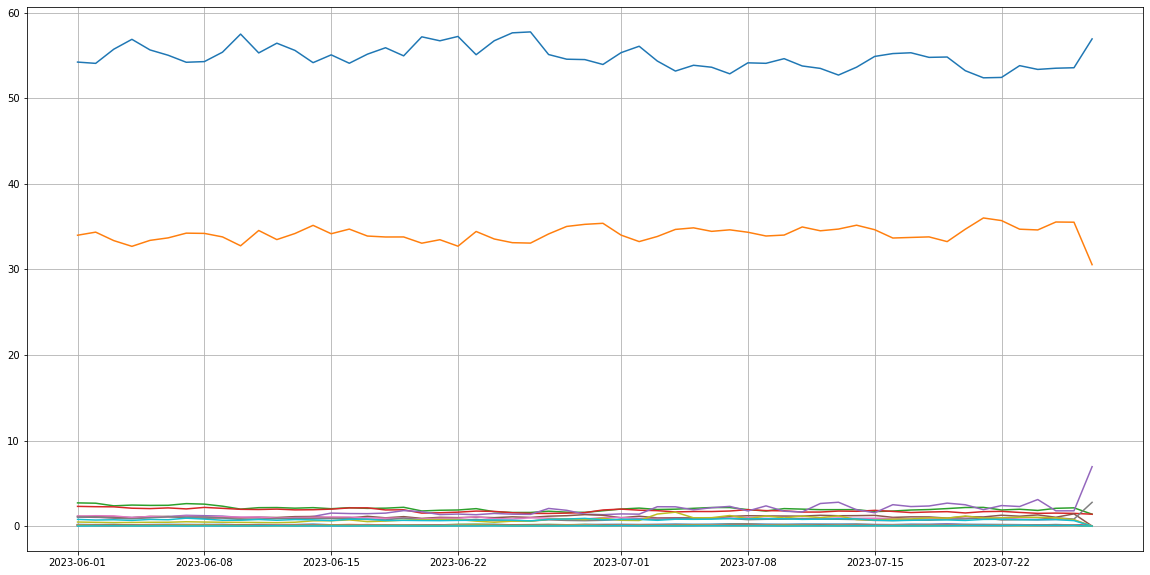

In [244]:
plt.figure(figsize=(20,10))

for el in assembly_issue_df_agg.columns[1:-1]:
    plt.plot(assembly_issue_df_agg.date, assembly_issue_df_agg[el], label = el)


plt.grid()
#plt.legend()


In [245]:
for el in assembly_issue_df_agg.columns[1:-1]:
    assembly_issue_df_agg[el] = \
    assembly_issue_df_agg[el].astype(int)

In [246]:
assembly_issue_df_agg['date'] = pd.to_datetime(assembly_issue_df_agg.date)

Причина - 
Отмена: клиент передумал покупать - вырос с 1 до 2-3 процентов от всего объема отмен
Отмена: внешний вид / качество упаковки - упал с 2 до 1 процента от всего объема отмен
ОЗ нет в наличии упала с 89-90 до 88-86

In [247]:
assembly_issue_df_agg[['ОЗ нет в наличии']] = assembly_issue_df_agg['Отмена: нет в наличии']\
+assembly_issue_df_agg['Замена: нет в наличии']

In [321]:
a1 = \
pd.DataFrame(assembly_issue_df_agg[assembly_issue_df_agg['date']<pd.to_datetime(test_start)].median())\
.rename(columns = {0:"Медиана доли в Спокойный период"})
a1 = a1.reset_index()

a2 = \
pd.DataFrame(assembly_issue_df_agg[assembly_issue_df_agg['date']>pd.to_datetime(test_end)].median())\
.rename(columns = {0:"Медиана доли в Странный период"})
a2 = a2.reset_index()

/tmp/ipykernel_737/95266235.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pd.DataFrame(assembly_issue_df_agg[assembly_issue_df_agg['date']<pd.to_datetime(test_start)].median())\
/tmp/ipykernel_737/95266235.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pd.DataFrame(assembly_issue_df_agg[assembly_issue_df_agg['date']>pd.to_datetime(test_end)].median())\


In [323]:
a_new  = a1.merge(a2)

In [325]:
a_new['abs_dif'] = np.abs(a_new['Медиана доли в Спокойный период'] - a_new['Медиана доли в Странный период'])

In [328]:
a_new.sort_values(by = 'abs_dif', ascending=False)

,index,Медиана доли в Спокойный период,Медиана доли в Странный период,abs_dif
20,items_cnt,100726.0,103276.5,2550.5
0,Отмена: нет в наличии,55.0,53.0,2.0
6,Замена: внешний вид / качество упаковки,1.0,0.0,1.0
1,Замена: нет в наличии,33.0,34.0,1.0
21,ОЗ нет в наличии,88.0,87.0,1.0
2,Отмена: сроки годности,2.0,1.0,1.0
3,Отмена: внешний вид / качество упаковки,2.0,1.0,1.0
4,Отмена: клиент передумал покупать,1.0,2.0,1.0
5,Отмена: другое (в том числе отказ клиента от замены),1.0,1.0,0.0
15,Замена: цена на полке отличается (выше цены сбермаркет более чем на 5 р.),0.0,0.0,0.0


In [330]:
assembly_issue_df_agg

,date,Отмена: нет в наличии,Замена: нет в наличии,Отмена: сроки годности,Отмена: внешний вид / качество упаковки,Отмена: клиент передумал покупать,Отмена: другое (в том числе отказ клиента от замены),Замена: внешний вид / качество упаковки,Замена: сроки годности,Замена: клиент передумал покупать,Замена: другое (в том числе отказ клиента от замены),Замена: ошибка в наименовании/описании,Замена: маркировка не сканируется,Отмена: маркировка не сканируется,Отмена: вес не соответствует,Отмена: на товаре нет маркировки,Замена: цена на полке отличается (выше цены сбермаркет более чем на 5 р.),Отмена: цена на полке отличается (выше цены сбермаркет более чем на 5 р.),Отмена: ошибка в наименовании/описании,Замена: вес не соответствует,Замена: на товаре нет маркировки,items_cnt,ОЗ нет в наличии
0,2023-06-01,54,33,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,80984,87
1,2023-06-02,54,34,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,100726,88
2,2023-06-03,55,33,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,120775,88
3,2023-06-04,56,32,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114511,88
4,2023-06-05,55,33,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,91832,88
5,2023-06-06,55,33,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,84030,88
6,2023-06-07,54,34,2,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,85034,88
7,2023-06-08,54,34,2,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,87481,88
8,2023-06-09,55,33,2,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,105369,88
9,2023-06-10,57,32,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,127707,89


## Смотрим по ритейлерам

In [342]:
a = final_df.groupby(['date','retailer_name']).sum()[['rc_count']]

In [343]:
sum_rc_count = final_df.groupby('date')[['rc_count']].sum().reset_index()

In [344]:
sum_rc_count['total_rc_count']=sum_rc_count.rc_count
sum_rc_count=sum_rc_count[['date','total_rc_count']]

In [345]:
a = a.reset_index().merge(sum_rc_count)

In [346]:
a['rc_prc'] = a['rc_count']*100/a['total_rc_count']
a['rc_prc'] = a['rc_prc'].astype(int)

In [347]:
a = a.query('rc_prc>=1')

In [348]:
a = pd.pivot_table(a, values='rc_prc', index=['date'],
                    columns=['retailer_name'], aggfunc=np.sum).fillna(0)\
.reset_index()

In [349]:
for c in a.columns[1:]:
    a[c]=a[c].astype(int)

In [350]:
a.style.applymap(lambda x: "color:black;background-color:#ffe9e3;" 
                               if x>=pd.to_datetime(test_end)
                 or x <=pd.to_datetime(test_start)
                               else "color:black;background-color:#c4c1e0;"
                ,subset='date')

retailer_name,date,METRO,SELGROS,АЛЛЕЯ,АШАН,ГЛОБУС,ДИКСИ,ЛЕНТА,ЛЕНТА EXPRESS,МАГНИТ,МАГНИТ КОСМЕТИК,МАГНИТ СЕМЕЙНЫЙ,МАГНИТ СЕМЕЙНЫЙ ЭКСПРЕСС,О'КЕЙ,ПЕРЕКРЕСТОК,ПЯТЕРОЧКА,САМОКАТ
0,2023-06-01,13,0,0,19,4,1,24,1,10,0,6,0,5,1,2,1
1,2023-06-02,13,0,0,19,4,0,24,1,9,0,7,0,5,1,2,1
2,2023-06-03,14,0,0,20,5,0,23,0,8,0,6,0,5,1,2,1
3,2023-06-04,15,0,0,18,4,0,24,1,8,0,6,0,6,1,2,1
4,2023-06-05,14,0,0,18,3,0,24,1,8,0,6,0,5,1,2,2
5,2023-06-06,13,0,0,18,3,1,24,1,9,0,6,1,5,1,2,2
6,2023-06-07,13,0,0,17,3,1,24,1,10,0,6,1,5,1,2,1
7,2023-06-08,14,0,0,18,3,1,24,1,10,0,6,0,5,1,2,1
8,2023-06-09,13,0,0,18,5,0,24,1,8,0,6,0,4,1,3,2
9,2023-06-10,13,0,0,17,5,0,23,1,8,0,6,0,4,1,4,5


In [351]:
a1 = \
pd.DataFrame(a[a['date']<pd.to_datetime(test_start)].median())\
.rename(columns = {0:"Медиана доли в Спокойный период"})
a1 = a1.reset_index()

a2 = \
pd.DataFrame(a[a['date']>pd.to_datetime(test_end)].median())\
.rename(columns = {0:"Медиана доли в Странный период"})
a2 = a2.reset_index()

In [352]:
a_new  = a1.merge(a2)

In [353]:
a_new['abs_dif'] = np.abs(a_new['Медиана доли в Спокойный период'] - a_new['Медиана доли в Странный период'])

In [354]:
a_new.sort_values(by = 'abs_dif', ascending=False)

,retailer_name,Медиана доли в Спокойный период,Медиана доли в Странный период,abs_dif
0,METRO,13.0,15.0,2.0
3,АШАН,18.0,17.0,1.0
5,ДИКСИ,0.0,1.0,1.0
7,ЛЕНТА EXPRESS,1.0,0.0,1.0
12,О'КЕЙ,5.0,6.0,1.0
14,ПЯТЕРОЧКА,2.0,1.0,1.0
1,SELGROS,0.0,0.0,0.0
2,АЛЛЕЯ,0.0,0.0,0.0
4,ГЛОБУС,4.0,4.0,0.0
6,ЛЕНТА,24.0,24.0,0.0


Небольшой рост у Ленты и Магнита, падение у Перекрестка

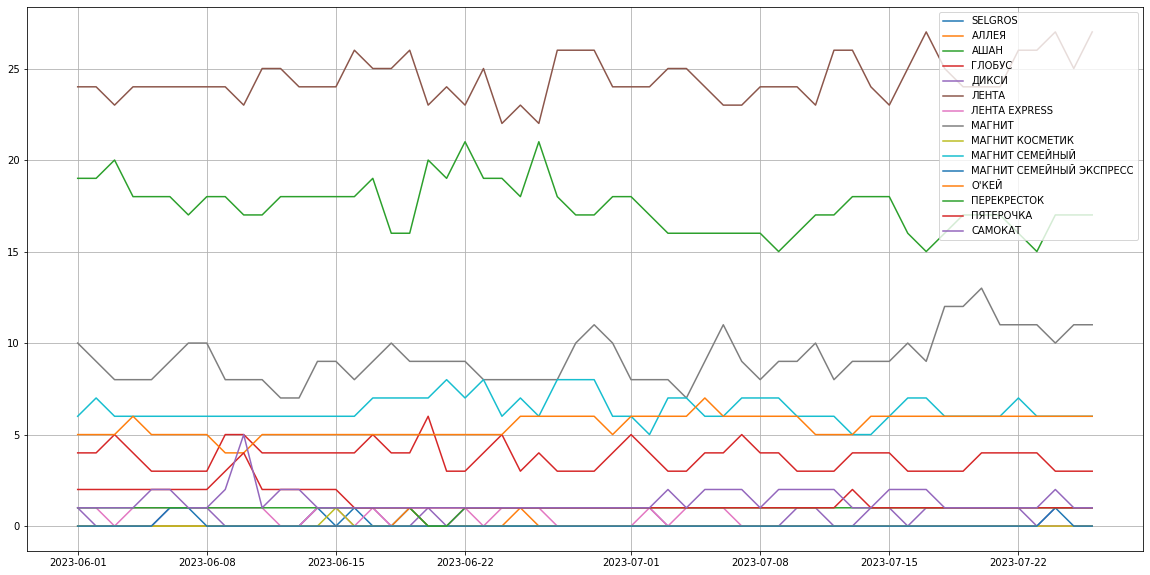

In [259]:
plt.figure(figsize=(20,10))

for c in a.columns[1:]:
    plt.plot(a.index, a[c], label = c)
    
#plt.axvline(x=pd.to_datetime('2023-03-03'), c='r')

plt.grid()
plt.legend()

Проверяем мастер категории

In [260]:
b = final_df.groupby(['date','master_category','express_delivery'])[['total_cnt','rc_count']]\
.sum().reset_index().query('master_category>""')

In [261]:
total_cnt_df = \
final_df.groupby(['date'])['rc_count'].sum().reset_index()

In [262]:
b = b.merge(total_cnt_df, left_on = 'date', right_on = 'date',suffixes=('_mc', '_all_mcs'))

In [263]:
b1 = b[['date','master_category','rc_count_mc','rc_count_all_mcs']]

In [264]:
b1['rc_prc'] = b1['rc_count_mc']/b1['rc_count_all_mcs']

/tmp/ipykernel_737/732564918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1['rc_prc'] = b1['rc_count_mc']/b1['rc_count_all_mcs']


In [266]:
b_agg = \
b1.query("rc_count_mc>0").sort_values(by='rc_prc', ascending=False).reset_index(drop=True)

In [267]:
b_agg.iloc[:int(b_agg.shape[0]*0.05)]

,date,master_category,rc_count_mc,rc_count_all_mcs,rc_prc
0,2023-07-01,Свежие овощи,9409,101952,0.092289
1,2023-07-10,Свежие овощи,9352,107390,0.087084
2,2023-07-14,Свежие овощи,10127,116567,0.086877
3,2023-07-13,Свежие овощи,9255,107381,0.086188
4,2023-07-08,Свежие овощи,9448,109664,0.086154
...,...,...,...,...,...
2216,2023-06-08,Салаты и закуски,554,87481,0.006333
2217,2023-07-13,Мясо птицы,680,107381,0.006333
2218,2023-06-09,Соусы,667,105368,0.006330
2219,2023-06-03,Салаты и закуски,764,120774,0.006326


In [268]:
a1=b_agg[b_agg['date']>pd.to_datetime(test_end)]\
.groupby('master_category')\
[['rc_prc']].agg(['count','mean','max']).sort_values(by = ('rc_prc',"max"), ascending = False)\
.head(10)

a2=b_agg[(b_agg['date']<pd.to_datetime(test_start))]\
.groupby('master_category')\
[['rc_prc']].agg(['count','mean','max']).sort_values(by = ('rc_prc',"max"), ascending = False)\
.head(10)

In [269]:
a1 = a1.rename(columns={'count':'Странный период - Количество дней',\
                   'mean':'Странный период - среднее значение rc_prc',\
                   'max':'Странный период - максимальное значение rc_prc'}).reset_index()

In [270]:
a2 = a2.rename(columns={'count':'Спокойный период - Количество дней',\
                   'mean':'Спокойный период - среднее значение rc_prc',\
                   'max':'Спокойный период - максимальное значение rc_prc'}).reset_index()

In [271]:
mc_agg_rc_df = a1.merge(a2, how='outer').fillna(0)

In [272]:
mc_agg_rc_df.columns = ['master_category','Странный период - Количество дней',
       'Странный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
                        
      'Спокойный период - Количество дней',
       'Спокойный период - среднее значение rc_prc',
       'Спокойный период - максимальное значение rc_prc']

In [273]:
for el in ['Спокойный период - максимальное значение rc_prc',
       'Спокойный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
       'Странный период - среднее значение rc_prc']:
    mc_agg_rc_df[el] = mc_agg_rc_df[el].apply(lambda x:int(np.round(x*100)))

В разбивке по МК 
* чаще стали заменять
    * Мороженое
* реже стали заменять
    * Корма для животных

In [274]:
mc_agg_rc_df[['master_category',
       'Спокойный период - максимальное значение rc_prc',
       'Спокойный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
       'Странный период - среднее значение rc_prc']]

,master_category,Спокойный период - максимальное значение rc_prc,Спокойный период - среднее значение rc_prc,Странный период - максимальное значение rc_prc,Странный период - среднее значение rc_prc
0,Свежие овощи,8,4,9,4
1,Мясо птицы,5,2,4,2
2,"Хлеб, тосты, лаваш",4,2,4,2
3,Свежие фрукты,3,2,3,2
4,Сыры,3,2,3,2
5,Полуфабрикаты из мяса и птицы,3,1,3,1
6,Мороженое,0,0,2,1
7,Творог и творожная масса,2,1,2,1
8,"Булочки, пироги, выпечка",2,1,2,1
9,"Зелень, салаты, смеси",2,1,2,1


In [275]:
b_express = b.query('express_delivery==1')\
[['date','master_category','rc_count_mc','rc_count_all_mcs']]

In [276]:
b_express['rc_prc'] = b_express['rc_count_mc']/b_express['rc_count_all_mcs']

In [277]:
b_agg_express = \
b_express.query("rc_count_mc>0").sort_values(by='rc_prc', ascending=False).reset_index(drop=True)

In [278]:
a1=b_agg_express[b_agg_express['date']>pd.to_datetime(test_end)]\
.groupby('master_category')\
[['rc_prc']].agg(['count','mean','max']).sort_values(by = ('rc_prc',"max"), ascending = False)\
.head(10)

a2=b_agg_express[(b_agg_express['date']<pd.to_datetime(test_start))]\
.groupby('master_category')\
[['rc_prc']].agg(['count','mean','max']).sort_values(by = ('rc_prc',"max"), ascending = False)\
.head(10)



In [279]:
a1 = a1.rename(columns={'count':'Странный период - Количество дней',\
                   'mean':'Странный период - среднее значение rc_prc',\
                   'max':'Странный период - максимальное значение rc_prc'}).reset_index()

In [280]:
a2 = a2.rename(columns={'count':'Спокойный период - Количество дней',\
                   'mean':'Спокойный период - среднее значение rc_prc',\
                   'max':'Спокойный период - максимальное значение rc_prc'}).reset_index()

In [281]:
mc_agg_rc_df = a1.merge(a2, how='outer').fillna(0)

In [282]:
mc_agg_rc_df.columns = ['master_category','Странный период - Количество дней',
       'Странный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
                        
      'Спокойный период - Количество дней',
       'Спокойный период - среднее значение rc_prc',
       'Спокойный период - максимальное значение rc_prc']

In [283]:
for el in ['Спокойный период - максимальное значение rc_prc',
       'Спокойный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
       'Странный период - среднее значение rc_prc']:
    mc_agg_rc_df[el] = mc_agg_rc_df[el].apply(lambda x:int(np.round(x*100)))

In [284]:
mc_agg_rc_df[['master_category',
       'Спокойный период - максимальное значение rc_prc',
       'Спокойный период - среднее значение rc_prc',
       'Странный период - максимальное значение rc_prc',
       'Странный период - среднее значение rc_prc']]

,master_category,Спокойный период - максимальное значение rc_prc,Спокойный период - среднее значение rc_prc,Странный период - максимальное значение rc_prc,Странный период - среднее значение rc_prc
0,Свежие овощи,3,2,2,1
1,"Хлеб, тосты, лаваш",1,1,1,1
2,Свежие фрукты,1,1,1,1
3,Мясо птицы,1,1,1,1
4,Корма для животных,1,0,1,1
5,Мороженое,1,1,1,1
6,Сыры,1,1,1,1
7,Молоко,1,0,1,0
8,Вода питьевая и минеральная,0,0,0,0
9,"Булочки, пироги, выпечка",1,0,0,0


В экспрессе, разбивке по МК 
* чаще стали заменять
    * Корма для животных
* реже стали заменять
    * Свежие овощи

In [177]:
oos_block_df = \
read_sql_query(f'''
select
     toDate(oos.created_at) as create_date
    ,oos.retailer_id
    ,mc_1.name as master_category_name
    ,sum(cnt) as sum_cnt
    ,sum(offers_sum) as sum_offers_sum
from
    content_availability.out_of_stock_agg_block as oos
    join
    analytics.int_master_categories as mc_1 on oos.master_category_id = mc_1.id  
where create_date between toDate('{start_date}') and  toDate('{end_date}')  

group by create_date,oos.retailer_id,master_category_name
''')

In [359]:
oos_block_df_agg = \
oos_block_df.groupby('create_date')[['sum_cnt','sum_offers_sum']].sum().reset_index()

In [360]:
oos_block_df_agg['prc'] = \
1 - oos_block_df_agg.sum_cnt/oos_block_df_agg.sum_offers_sum

In [361]:
oos_block_df_agg

,create_date,sum_cnt,sum_offers_sum,prc
0,2023-06-01,79113179,89414768,0.115211
1,2023-06-02,78608011,88503037,0.111804
2,2023-06-03,79159265,89172108,0.112287
3,2023-06-04,77692284,87448121,0.111561
4,2023-06-05,77806976,87679807,0.112601
5,2023-06-06,77812257,87645578,0.112194
6,2023-06-07,81111563,92442834,0.122576
7,2023-06-08,80183473,92023310,0.128661
8,2023-06-09,80441312,91725804,0.123024
9,2023-06-10,77902802,89107239,0.125741


Видим рост блокировок и рост ОЗ

(0.0, 0.1613254713466419)

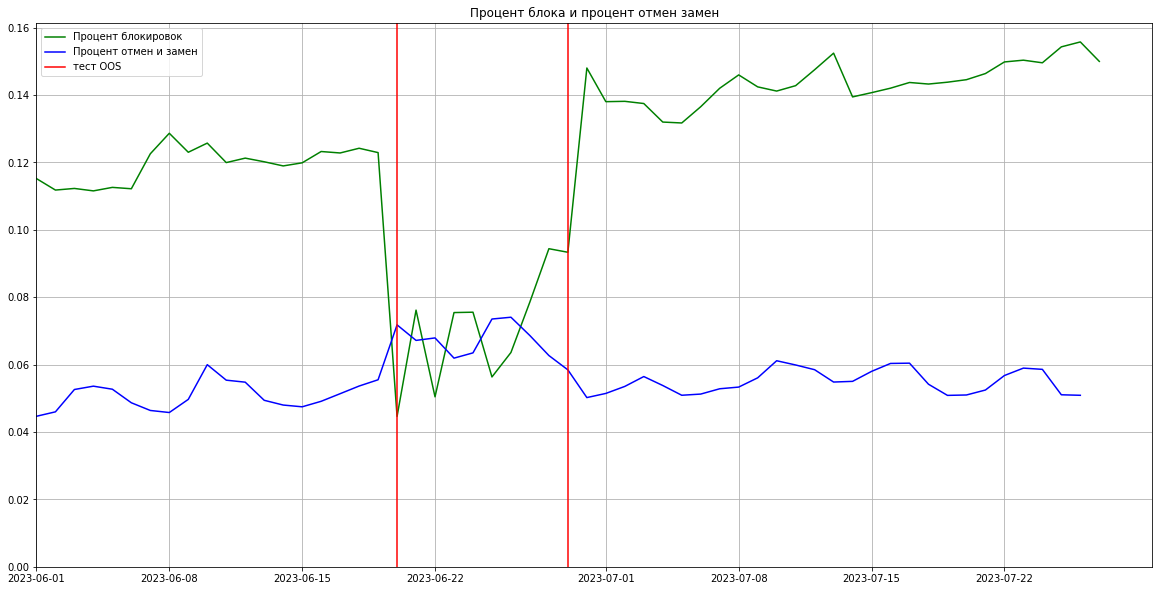

In [364]:
#plt.style.use('dark_background')
plt.figure(figsize=(20,10))

plt.plot(oos_block_df_agg.create_date, oos_block_df_agg.prc, label = 'Процент блокировок', color = 'g')

plt.plot(final_df_group.date, final_df_group.rc_prc, label ='Процент отмен и замен', color = 'b')

    
plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'тест OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r')

plt.xlim(pd.to_datetime(start_date),)
plt.grid()
plt.legend()
plt.title("Процент блока и процент отмен замен")
plt.ylim(0,)
    

## Отмены по городам

In [289]:
a = final_df.groupby(['date','city']).sum()[['rc_count']]

In [290]:
sum_rc_count = final_df.groupby('date')[['rc_count']].sum().reset_index()

In [291]:
sum_rc_count['total_rc_count']=sum_rc_count.rc_count
sum_rc_count=sum_rc_count[['date','total_rc_count']]

In [292]:
a = a.reset_index().merge(sum_rc_count)

In [293]:
a['rc_prc'] = a['rc_count']*100/a['total_rc_count']
a['rc_prc'] = a['rc_prc'].astype(int)

In [294]:
a = a.query('rc_prc>=1')

In [295]:
a = pd.pivot_table(a, values='rc_prc', index=['date'],
                    columns=['city'], aggfunc=np.sum).fillna(0)\
.reset_index()

In [296]:
for c in a.columns[1:]:
    a[c]=a[c].astype(int)

In [297]:
a.style.applymap(lambda x: "color:black;background-color:#ffe9e3;" 
                               if x>=pd.to_datetime(test_end)
                 or x <=pd.to_datetime(test_start)
                               else "color:black;background-color:#c4c1e0;"
                ,subset='date')

city,date,Астрахань,Барнаул,Волгоград,Воронеж,Екатеринбург,Ижевск,Иркутск,Казань,Кемерово,Краснодар,Красноярск,Москва,Московская область,Мурманск,Нижний Новгород,Новороссийск,Новосибирск,Омск,Пермь,Ростов-на-Дону,Самара,Санкт-Петербург,Саратов,Сочи,Сургут,Тольятти,Тула,Тюмень,Ульяновск,Уфа,Чебоксары,Челябинск
0,2023-06-01,0,0,2,1,2,0,1,1,0,3,2,18,9,0,1,0,3,2,1,2,2,6,1,0,0,0,0,2,0,2,0,2
1,2023-06-02,0,0,2,1,2,0,1,1,0,3,2,18,10,0,1,0,3,1,1,2,2,6,1,0,0,0,0,2,0,1,0,2
2,2023-06-03,1,0,2,1,2,0,1,1,0,2,2,20,12,0,1,0,2,1,1,2,1,6,1,0,0,0,0,1,0,1,0,1
3,2023-06-04,1,0,2,1,3,0,1,1,0,2,2,20,10,0,1,0,3,1,0,2,1,7,1,0,0,0,0,1,0,1,0,1
4,2023-06-05,0,0,2,1,3,0,1,1,0,2,2,19,9,0,1,0,3,1,1,2,1,6,1,0,0,0,0,2,0,1,0,1
5,2023-06-06,0,1,2,1,2,1,1,1,0,3,2,18,8,0,1,0,3,1,1,2,2,6,1,0,0,0,0,1,0,1,0,1
6,2023-06-07,1,0,2,1,2,0,1,1,0,3,3,17,8,0,1,0,3,2,1,2,2,6,1,1,0,0,0,2,0,2,0,1
7,2023-06-08,0,0,2,1,3,0,1,1,0,2,2,18,8,0,1,0,3,2,1,2,2,6,1,0,0,0,0,1,0,2,0,1
8,2023-06-09,0,0,2,1,2,0,1,1,0,3,2,18,10,0,1,0,3,1,1,2,2,7,1,0,0,0,0,1,0,1,0,1
9,2023-06-10,1,0,2,0,3,0,1,1,0,2,2,18,11,0,1,0,3,1,1,2,2,7,0,1,0,0,0,1,0,1,0,1


In [298]:
a = a.set_index('date')

Небольшой рост у Ленты и Магнита, падение у Перекрестка

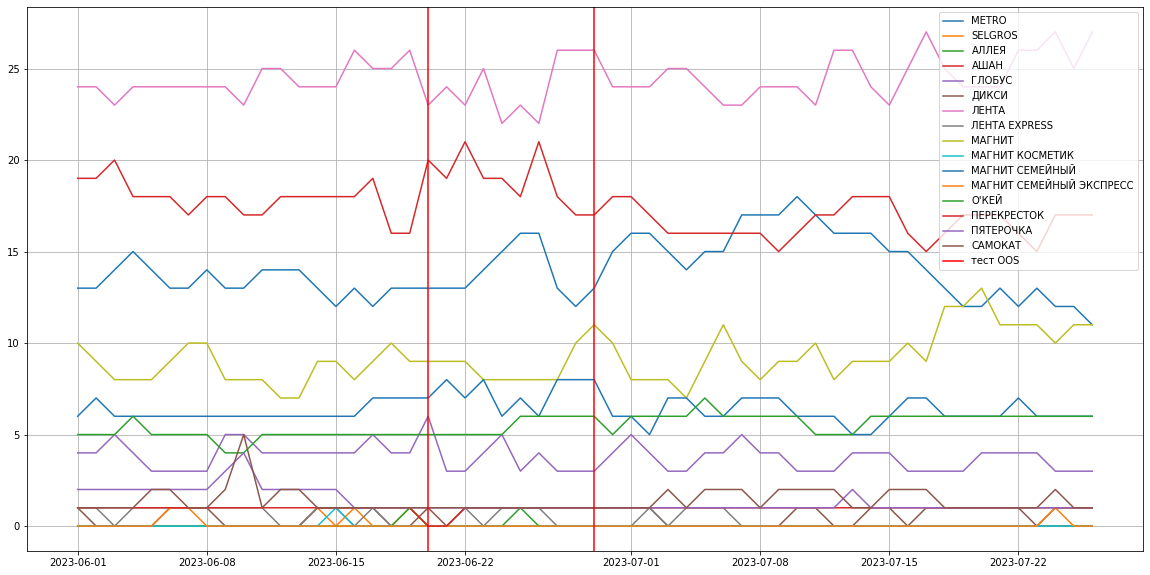

In [356]:
plt.figure(figsize=(20,10))

for c in a.columns[1:]:
    plt.plot(a.date, a[c], label = c)
    

plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'тест OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r')

plt.grid()
plt.legend()

# Часть 2 - СТМ СП

In [3]:
q = '''
select product_product.id
from product_product
JOIN master_category_mastercategory ON master_category_mastercategory.id = product_product.master_category_id
LEFT JOIN master_category_mastercategory AS parent ON parent.id = master_category_mastercategory.parent_id
JOIN infomodel_infomodel ON infomodel_infomodel.master_category_id = product_product.master_category_id
                         OR infomodel_infomodel.master_category_id = master_category_mastercategory.parent_id
                         OR infomodel_infomodel.master_category_id = parent.parent_id
JOIN infomodel_boundcharacteristic ON infomodel_boundcharacteristic.infomodel_id = infomodel_infomodel.id
LEFT JOIN characteristic_characteristic ON characteristic_characteristic.id = infomodel_boundcharacteristic.characteristic_id
LEFT JOIN product_productcharacteristicvalues ON infomodel_boundcharacteristic.id = ANY(product_productcharacteristicvalues.characteristics)
                                             AND product_productcharacteristicvalues.product_id = product_product.id
LEFT JOIN LATERAL (SELECT string_agg(value, ';') AS att_value,
                          string_agg(id::text, ';') AS att_value_id
                     FROM refbook_referencevalue
                    WHERE id = ANY(CASE
                                       WHEN characteristic_characteristic.type = ANY(ARRAY[3, 4])  /* 3 - поле с 1 выбором значений, 4 - с множеством. В обоих полях лежит массив refbook_referencevalue */
                                       THEN translate((values->>(infomodel_boundcharacteristic.id::varchar))::text,'[]','{}')::int[]
                                    END)
 ) AS att_values ON true
 where 1=1
 and characteristic_characteristic.id = 50001 
 and att_value = 'СТМ'
'''

In [4]:
a = read_sql_query(q, con = 'pims')

In [5]:
read_sql_query(f'''
drop TABLE IF EXISTS sandbox.ds_tmp_stm ON CLUSTER 'shard_group_old'
''')


read_sql_query('''
CREATE TABLE IF NOT EXISTS  sandbox.ds_tmp_stm ON CLUSTER 'shard_group_old' (
                                              sku                               String
                                              
                                              )
         ENGINE = ReplicatedMergeTree('/tables/{shard}/sandbox/ds_tmp_stm'
                                              , '{replica}')
                                              PARTITION BY tuple()
                                              ORDER BY tuple()
                                              SETTINGS index_granularity = 8192
''')

,host,port,status,error,num_hosts_remaining,num_hosts_active
0,rc1a-j3joexl73w6v2uln.mdb.yandexcloud.net,9440,0,,2,2
1,rc1c-c9a7xwun7d2daqfv.mdb.yandexcloud.net,9440,0,,1,0
2,rc1c-2xcz4mna6pofx64b.mdb.yandexcloud.net,9440,0,,0,0


In [16]:
a['sku'] = a['sku'].astype(str)

/tmp/ipykernel_194/1327230427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['sku'] = a['sku'].astype(str)


In [17]:
read_sql_query(a,
               to_sql = True, 
               name = 'ds_tmp_stm', 
               con = 'click', 
               if_exists = 'append', 
               schema = 'sandbox',
               index=False)

In [9]:
%%time
df_list=[]

for date in tqdm(pd.date_range(start='2023-06-01', end='2023-08-05')):
    print(date.strftime("%Y-%m-%d"))
    a = read_sql_query(f'''
    SELECT
        toDate(shipment_shipped_at) AS date,
        master_category,
        city,
        express_delivery,
        retailer_name,
        tenant_id,
        stm.sku!='' as is_stm,
        sumIf(1, rc_status != 'ok') AS rc_count,
        sumIf(1, rc_status = 'replaced') AS repl_count,
        sumIf(1, rc_status = 'cancelled') AS canc_count,
        sum(multiIf((rc_status = 'cancelled') OR (is_deleted = 0), 1, 0)) AS total_cnt
    FROM
    (
        SELECT
            product_name,
            brand_name,
            toDate(shipment_shipped_at, 'Europe/Moscow') AS shipment_shipped_at,
            master_category,
            dictGet('analytics.master_categories_dict', 'parent_id', toUInt64(parent_category_id)) AS master_category_3_id,
            dictGet('analytics.master_categories_dict', 'name', toUInt64(parent_category_id)) AS master_category_2,
            dictGet('analytics.master_categories_dict', 'name', toUInt64(master_category_3_id)) AS master_category_3,
            city AS city,
            dictGet('analytics.store_details_dict', 'veeroute_identifier', toUInt64(store_id)) AS store_name,
            dictGet('analytics.stores_dict', 'express_delivery', toUInt64(store_id)) AS express_delivery,
            retailer_name AS retailer_name,
            tenant_id AS tenant_id,
            if((lv.line_item_id IS NOT NULL) AND (lv.line_item_id != 0), lv.to_item_id, 1) AS replaced_to,
            multiIf(replaced_to = 1, 'ok', replaced_to IS NULL, 'cancelled', 'replaced') AS rc_status,
            multiIf(dictGet('analytics.device_attributions_dict', 'client_identifier', toUInt64(order_id)) != '', dictGet('analytics.device_attributions_dict', 'client_identifier', toUInt64(order_id)), tenant_id = 'metro', 'WL Metro', 'SbermarketWeb') AS client_identifier,
            multiIf(li_deleted_at IS NOT NULL, 1, 0) AS is_deleted,
            stm.sku
            
        FROM analytics.line_items AS li
        LEFT JOIN
        (
            SELECT
                line_item_id,
                max(to_item_id) AS to_item_id
            FROM analytics.lirc_view
            GROUP BY line_item_id
        ) AS lv ON lv.line_item_id = toUInt64(li.line_item_id)
        left join sandbox.ds_tmp_stm stm on li.sku = stm.sku
        WHERE (toDate(shipment_shipped_at, 'Europe/Moscow') = toDate('{date}', 'Europe/Moscow')) AND (shipment_state = 'shipped')
    ) AS li_rc
    
    GROUP BY
        date,
        master_category,
        city,
        express_delivery,
        retailer_name,
        tenant_id,
        is_stm

    
    ''')
    
    df_list.append(a)
    a.to_feather(date.strftime("%Y-%m-%d")+'stm.feather')
    

  0%|          | 0/66 [00:00<?, ?it/s]

2023-06-01


  2%|▏         | 1/66 [02:52<3:06:20, 172.00s/it]

2023-06-02


  3%|▎         | 2/66 [07:12<3:59:11, 224.23s/it]

2023-06-03


  5%|▍         | 3/66 [10:57<3:55:41, 224.47s/it]

2023-06-04


  6%|▌         | 4/66 [13:06<3:12:50, 186.62s/it]

2023-06-05


  8%|▊         | 5/66 [14:37<2:34:54, 152.37s/it]

2023-06-06


  9%|▉         | 6/66 [16:18<2:14:45, 134.75s/it]

2023-06-07


 11%|█         | 7/66 [18:09<2:04:49, 126.95s/it]

2023-06-08


 12%|█▏        | 8/66 [22:36<2:45:59, 171.71s/it]

2023-06-09


 14%|█▎        | 9/66 [26:56<3:09:14, 199.20s/it]

2023-06-10


 15%|█▌        | 10/66 [30:41<3:13:28, 207.30s/it]

2023-06-11


 17%|█▋        | 11/66 [38:37<4:25:23, 289.52s/it]

2023-06-12


 18%|█▊        | 12/66 [41:22<3:46:22, 251.52s/it]

2023-06-13


 20%|█▉        | 13/66 [43:11<3:04:00, 208.31s/it]

2023-06-14


 21%|██        | 14/66 [44:52<2:32:30, 175.98s/it]

2023-06-15


 23%|██▎       | 15/66 [46:50<2:14:35, 158.35s/it]

2023-06-16


 24%|██▍       | 16/66 [48:36<1:58:48, 142.57s/it]

2023-06-17


 26%|██▌       | 17/66 [56:20<3:15:32, 239.43s/it]

2023-06-18


 27%|██▋       | 18/66 [1:02:21<3:40:50, 276.05s/it]

2023-06-19


 29%|██▉       | 19/66 [1:07:36<3:45:11, 287.47s/it]

2023-06-20


 30%|███       | 20/66 [1:11:04<3:22:17, 263.85s/it]

2023-06-21


 32%|███▏      | 21/66 [1:14:43<3:07:46, 250.37s/it]

2023-06-22


 33%|███▎      | 22/66 [1:18:12<2:54:20, 237.74s/it]

2023-06-23


 35%|███▍      | 23/66 [1:22:39<2:56:44, 246.61s/it]

2023-06-24


 36%|███▋      | 24/66 [1:27:00<2:55:34, 250.82s/it]

2023-06-25


 38%|███▊      | 25/66 [1:32:40<3:09:48, 277.78s/it]

2023-06-26


 39%|███▉      | 26/66 [1:37:15<3:04:38, 276.95s/it]

2023-06-27


 41%|████      | 27/66 [1:39:35<2:33:16, 235.80s/it]

2023-06-28


 42%|████▏     | 28/66 [1:41:56<2:11:18, 207.33s/it]

2023-06-29


 44%|████▍     | 29/66 [1:44:00<1:52:21, 182.20s/it]

2023-06-30


 45%|████▌     | 30/66 [1:46:29<1:43:24, 172.34s/it]

2023-07-01


 47%|████▋     | 31/66 [1:52:26<2:12:55, 227.87s/it]

2023-07-02


 48%|████▊     | 32/66 [1:58:11<2:29:00, 262.94s/it]

2023-07-03


 50%|█████     | 33/66 [2:05:18<2:51:37, 312.04s/it]

2023-07-04


 52%|█████▏    | 34/66 [2:08:47<2:30:04, 281.38s/it]

2023-07-05


 53%|█████▎    | 35/66 [2:11:36<2:07:50, 247.43s/it]

2023-07-06


 55%|█████▍    | 36/66 [2:13:48<1:46:24, 212.83s/it]

2023-07-07


 56%|█████▌    | 37/66 [2:15:52<1:29:58, 186.15s/it]

2023-07-08


 58%|█████▊    | 38/66 [2:17:59<1:18:38, 168.53s/it]

2023-07-09


 59%|█████▉    | 39/66 [2:20:37<1:14:24, 165.35s/it]

2023-07-10


 61%|██████    | 40/66 [2:22:26<1:04:17, 148.36s/it]

2023-07-11


 62%|██████▏   | 41/66 [2:24:17<57:09, 137.17s/it]  

2023-07-12


 64%|██████▎   | 42/66 [2:25:56<50:21, 125.89s/it]

2023-07-13


 65%|██████▌   | 43/66 [2:27:30<44:32, 116.18s/it]

2023-07-14


 67%|██████▋   | 44/66 [2:29:26<42:34, 116.10s/it]

2023-07-15


 68%|██████▊   | 45/66 [2:31:28<41:16, 117.95s/it]

2023-07-16


 70%|██████▉   | 46/66 [2:33:42<40:54, 122.70s/it]

2023-07-17


 71%|███████   | 47/66 [2:35:33<37:47, 119.34s/it]

2023-07-18


 73%|███████▎  | 48/66 [2:37:19<34:31, 115.09s/it]

2023-07-19


 74%|███████▍  | 49/66 [2:39:11<32:20, 114.18s/it]

2023-07-20


 76%|███████▌  | 50/66 [2:41:18<31:32, 118.29s/it]

2023-07-21


 77%|███████▋  | 51/66 [2:43:42<31:28, 125.88s/it]

2023-07-22


 79%|███████▉  | 52/66 [2:46:04<30:29, 130.64s/it]

2023-07-23


 80%|████████  | 53/66 [2:48:12<28:10, 130.01s/it]

2023-07-24


 82%|████████▏ | 54/66 [2:52:20<33:03, 165.29s/it]

2023-07-25


 83%|████████▎ | 55/66 [2:56:20<34:26, 187.85s/it]

2023-07-26


 85%|████████▍ | 56/66 [2:59:52<32:29, 194.96s/it]

2023-07-27


 86%|████████▋ | 57/66 [3:02:19<27:04, 180.51s/it]

2023-07-28


 88%|████████▊ | 58/66 [3:04:16<21:30, 161.37s/it]

2023-07-29


 89%|████████▉ | 59/66 [3:06:22<17:35, 150.79s/it]

2023-07-30


 91%|█████████ | 60/66 [3:08:35<14:33, 145.55s/it]

2023-07-31


 92%|█████████▏| 61/66 [3:10:18<11:04, 132.82s/it]

2023-08-01


 94%|█████████▍| 62/66 [3:12:05<08:19, 124.91s/it]

2023-08-02


 95%|█████████▌| 63/66 [3:13:26<05:35, 111.91s/it]

2023-08-03


 97%|█████████▋| 64/66 [3:14:46<03:24, 102.19s/it]

2023-08-04


 98%|█████████▊| 65/66 [3:16:01<01:34, 94.20s/it] 

2023-08-05


100%|██████████| 66/66 [3:17:12<00:00, 179.28s/it]

CPU times: user 1min 24s, sys: 20.2 s, total: 1min 45s
Wall time: 3h 17min 12s


In [11]:
b = pd.concat(df_list)

In [12]:
b.is_stm.sum()

1993950

In [15]:
b['is_stm'].value_counts()

0    8379313
1    1993950
Name: is_stm, dtype: int64

In [17]:
is_stm_df = b[b['is_stm']==True]

In [18]:
is_stm_df

,date,master_category,city,express_delivery,retailer_name,tenant_id,is_stm,rc_count,repl_count,canc_count,total_cnt
9,2023-06-01,Вода питьевая и минеральная,Челябинск,1,САМОКАТ,sbermarket,1,1,0,1,70
13,2023-06-01,Молоко,Киров,1,ПЯТЕРОЧКА,sbermarket,1,0,0,0,2
21,2023-06-01,Туалетная бумага и бумажные полотенца,Рязань,0,МАГНИТ СЕМЕЙНЫЙ,sbermarket,1,0,0,0,1
22,2023-06-01,"Печенье, пряники, вафли",Вологда,1,МАГНИТ,sbermarket,1,0,0,0,1
26,2023-06-01,Овощные консервы и соленья,Краснодар,0,АШАН,auchan,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
160534,2023-08-05,Прокладки и тампоны,Белгород,1,ПЯТЕРОЧКА,sbermarket,1,0,0,0,1
160539,2023-08-05,Консервы из рыбы и морепродуктов,Набережные Челны,0,МАГНИТ СЕМЕЙНЫЙ,sbermarket,1,0,0,0,1
160544,2023-08-05,"Соленая, копченая, вяленая рыба",Владимир,1,ДИКСИ,sbermarket,1,0,0,0,1
160553,2023-08-05,"Соки, нектары и морсы",Рязань,0,METRO,metro,1,0,0,0,1


In [19]:
final_df_group = \
is_stm_df.groupby('date')[['rc_count','repl_count','canc_count','total_cnt']].sum()\
.reset_index()

In [20]:
final_df_group['rc_prc']=final_df_group['rc_count']/final_df_group['total_cnt']
final_df_group['rep_prc']=final_df_group['repl_count']/final_df_group['total_cnt']
final_df_group['canc_prc']=final_df_group['canc_count']/final_df_group['total_cnt']

Text(0.5, 1.0, 'СТМ\nПроцент отмен, замен и их сумма ')

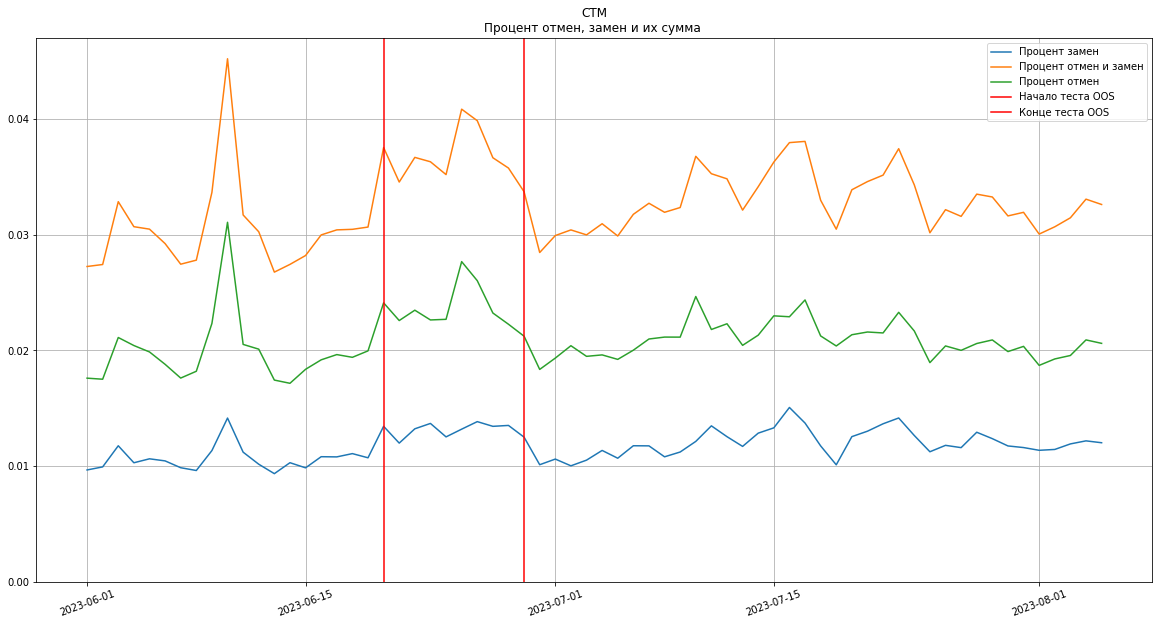

In [23]:
#plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.plot(final_df_group.date, final_df_group.rep_prc, label ='Процент замен')
plt.plot(final_df_group.date, final_df_group.rc_prc, label ='Процент отмен и замен')
plt.plot(final_df_group.date, final_df_group.canc_prc, label ='Процент отмен')

plt.axvline(x=pd.to_datetime(test_start), c='r', label = 'Начало теста OOS')
plt.axvline(x=pd.to_datetime(test_end), c='r', label = 'Конце теста OOS')
plt.xticks(rotation=20)
plt.grid()
plt.legend()
plt.ylim(0,)
plt.title("СТМ\nПроцент отмен, замен и их сумма ")

In [ ]:
cre